# Tópicos Avançados em Visão Computacional

## Usando técnicas de redes neurais para descrição automática de imagens

### Integrantes:

#### Jorge Augusto Salgado Salhani - 8927418
#### Leonardo Rossi Luiz - 10851691
#### Pedro Dias Batista - 10769809

## Download de bibliotecas utilizadas

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install tensorflow
!pip install keras
!pip install deeplake[enterprise]
!pip install deeplake
!pip install opencv-python

In [56]:
import os   # handling the files
import pickle # storing numpy features
import numpy as np
from tqdm.notebook import tqdm # how much data is process till now

import tensorflow as tf
import deeplake
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as T
import cv2

## Dataset flickr30k. 


### Downloaded via deeplake lib

In [9]:
ds = deeplake.load('hub://activeloop/flickr30k')

/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/flickr30k



-

hub://activeloop/flickr30k loaded successfully.



### Entendendo seu conteúdo


In [10]:
ds

Dataset(path='hub://activeloop/flickr30k', read_only=True, tensors=['caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4', 'image'])

O dataset é composto por

- path: url de referência para o dataset
- read_only: modo de leitura do arquivo (apenas para leitura, neste caso)
- tensors: lista de objetos Tensor com 5 captions ['caption_0', ..., 'caption_4'] e um objeto Tensor 'image' com os arquivos de imagens

Maiores informações: https://app.activeloop.ai/activeloop/flickr30k/



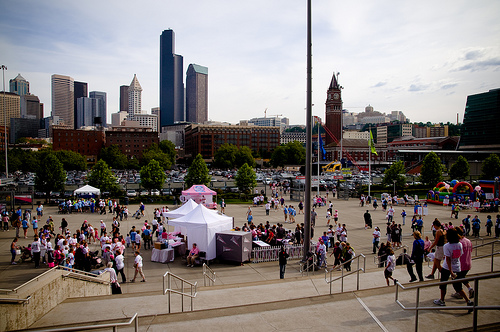

In [11]:
transform = torchvision.transforms.ToPILImage()
img = transform(ds.tensors['image'][0].numpy())
img.show()

In [12]:
for key, val in ds.tensors.items():
  if 'caption' in key:
    print(val[0].numpy())

['Crowds of people are walking are multicolored tents and flags that are put up outside in a cement lot as a big city looms in the distance .']
['Groups of people are in a urban park or walking towards the main area .']
['People enjoying themselves outDoors , maybe a fair is going on .']
['People are gathering for some event in the city .']
['A busy promenade where people gather .']


Neste exemplo acima podemos compreender melhor a presença de uma imagem e suas 5 descrições.

In [13]:
print(ds.tensors['caption_0'].shape)
print(ds.tensors['image'].shape)

(31783, 1)
(31783, None, None, 3)


E também notamos que existem 31783 ocorrências no dataset, sendo as captions de dimensão 1 (texto) e as imagens, de dimensão 3 (três matrizes para a escala de cores R,G,B)

### Extração de features do dataset

Importando a arquitetura VGG (16-layer) usando Keras

Mais informações: https://www.kaggle.com/code/blurredmachine/vggnet-16-architecture-a-complete-guide

In [14]:
from keras.applications.vgg16 import VGG16
model = VGG16()

In [15]:
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Na camada inicial (InputLayer), temos [(None, 224, 224, 3)].

Podemos inserir um número indefinido de entradas (None), porém as mesmas devem ser compostas por matrizes 224x224x3, ou seja, imagens com 3 filtros de cores (RGB, por exemplo) e 224x224 pixels.

Sabemos (via referência https://app.activeloop.ai/activeloop/flickr30k/) que as imagens apresentam intervalo de dimensão [112:500] x [164:500] pixels.

Logo, redimensionaremos todas as imagens para que sejam mantidas em 224x224

In [160]:
train_ds, test_ds = ds.random_split([0.2, 0.8]) 

In [161]:
print("Original: ", len(ds))
print("Reduzido (treino): ", len(train_ds))
print("Restante (teste): ", len(test_ds))

Original:  31783
Reduzido (treino):  6357
Restante (teste):  25426


Para o processamento inicial, vamos considerar apenas uma fração do dataset como base de treino. Nesse caso, utilizaremos 20\%, correspondente a 6357 imagens

In [145]:
features = {}
for idx, i in tqdm(enumerate(train_ds.index.values[0])):
  img_np = ds.tensors['image'][int(i.value)].numpy()
  transform = T.ToPILImage()
  img = transform(img_np)

  transform = T.Resize((224,224))
  image = transform(img)

  image = img_to_array(image)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  feature = model.predict(image, verbose=0)

  captions = []
  for cap_i in range(5):
    
    capt = str(ds.tensors[f'caption_{cap_i}'][int(i.value)].numpy()[0]).replace('[^A-Za-z]', '').replace('\s+', ' ')
    capt = capt.lower()
    capt = 'startseq ' + " ".join([word for word in capt.split() if len(word)>1]) + ' endseq'
    captions.append(capt)
  features[int(i.value)] = {'feature':feature[0], 'captions':captions}


0it [00:00, ?it/s]

Para que a tokenização das legendas possa ser realizada de modo mais eficiente, também utilizaremos um tokenizador para processamento de linguagem natural

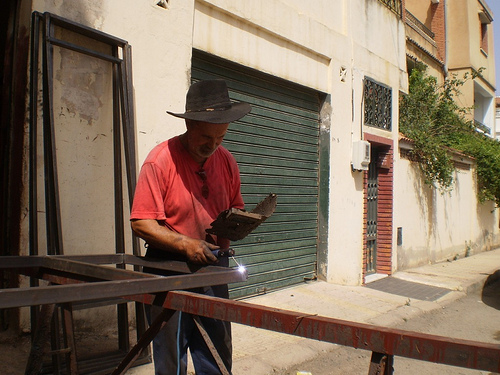

In [146]:
transform = torchvision.transforms.ToPILImage()
img = transform(ds.tensors['image'][18139].numpy())
img.show()

In [164]:
print(features[18139])
print("Tamanho (array de feature): ", len(features[18139]['feature']))
print()
features[18139]['captions']

{'feature': array([0.        , 1.5448062 , 0.09191111, ..., 0.        , 0.        ,
       0.8750518 ], dtype=float32), 'captions': ['startseq man wearing cowboy hat dirty red shirt and blue slacks stands on street holding leather or metal object in his left hand and perhaps solder device in his right hand as he appears to work on metal frame with couple similar metal frames stacked against the side of the building endseq', 'startseq male metal worker using welding tool in his right hand while holding the mask in his left hand in mid-lower or lower class neighborhood endseq', 'startseq man wearing red shirt jeans and black cowboy hat is welding on metal bars endseq', 'startseq man in black brimmed hat and red shirt is reading book in front of garage endseq', 'startseq carpenter takes break to read book endseq']}
Tamanho (array de feature):  4096



['startseq man wearing cowboy hat dirty red shirt and blue slacks stands on street holding leather or metal object in his left hand and perhaps solder device in his right hand as he appears to work on metal frame with couple similar metal frames stacked against the side of the building endseq',
 'startseq male metal worker using welding tool in his right hand while holding the mask in his left hand in mid-lower or lower class neighborhood endseq',
 'startseq man wearing red shirt jeans and black cowboy hat is welding on metal bars endseq',
 'startseq man in black brimmed hat and red shirt is reading book in front of garage endseq',
 'startseq carpenter takes break to read book endseq']

Neste exemplo acima fica evidente o formato das features extraídas como 

- um array de valores float com 4096 entradas
- um array de strings formatadas relativas a cada legenda original da imagem

In [156]:
all_captions = []
for key,val in features.items():
  all_captions += val['captions'] 

In [166]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print("Total de palavras: ", vocab_size)

Total de palavras:  315
